### Visualize Percentage Change

In [2]:
import pandas as pd 
import numpy as np

In [3]:
# Load data
all_df = pd.read_parquet("./exchangerates.parquet")

In [4]:
# Select only four major exchange rate to visualize 
# Too many columns with make the plot too hard to read 
target_currency = ["myr_usd", "myr_rmb", "myr_sgd", "myr_eur"]
selected_cols = ["date"] + target_currency

In [5]:
# Extract yearly dataframes from the original all_df
dfs = {
    2021: all_df[(all_df["date"] >= "2021-01-01") & (all_df["date"] <= "2021-12-31")][selected_cols],
    2022: all_df[(all_df["date"] >= "2022-01-01") & (all_df["date"] <= "2022-12-31")][selected_cols],
    2023: all_df[(all_df["date"] >= "2023-01-01") & (all_df["date"] <= "2023-12-31")][selected_cols],
    2024: all_df[(all_df["date"] >= "2024-01-01") & (all_df["date"] <= "2024-12-31")][selected_cols]
}

In [6]:
# Extract day and month from date column 
def extract_month_day(df):
    df["day"] = df["date"].apply(lambda x: x.day)
    df["month"] = df["date"].apply(lambda x: x.month)
    return df

In [7]:
result_dfs = {}
for year, df in dfs.items():
    if year == 2021: continue # Base year 

    print("Year", year)
    # Get previous year df 
    prev_year_df = dfs[year-1]

    # Extract day and month from the df
    df = extract_month_day(df)
    prev_year_df = extract_month_day(prev_year_df)

    # Join previous year df with current year on month and day
    result_df = df.merge(prev_year_df, on=["month", "day"], how="left")

    # For each currency
    for col in target_currency:
        # Calculate YoY difference
        result_df[f"{col}_diff"] = result_df[f"{col}_x"] - result_df[f"{col}_y"]

        # Calculate percentage
        # Formula = (last_year - this_year) / last_year
        result_df[f"{col}_pct_change"] = result_df[f"{col}_diff"] / result_df[f"{col}_y"]

    # Select only pct_change column and rename
    result_col = ["date_x"] + [f"{col}_pct_change" for col in target_currency]
    result_df = result_df[result_col]
    result_df = result_df.rename(columns={"date_x": "date"})
    result_dfs[year] = result_df


Year 2022
Year 2023
Year 2024


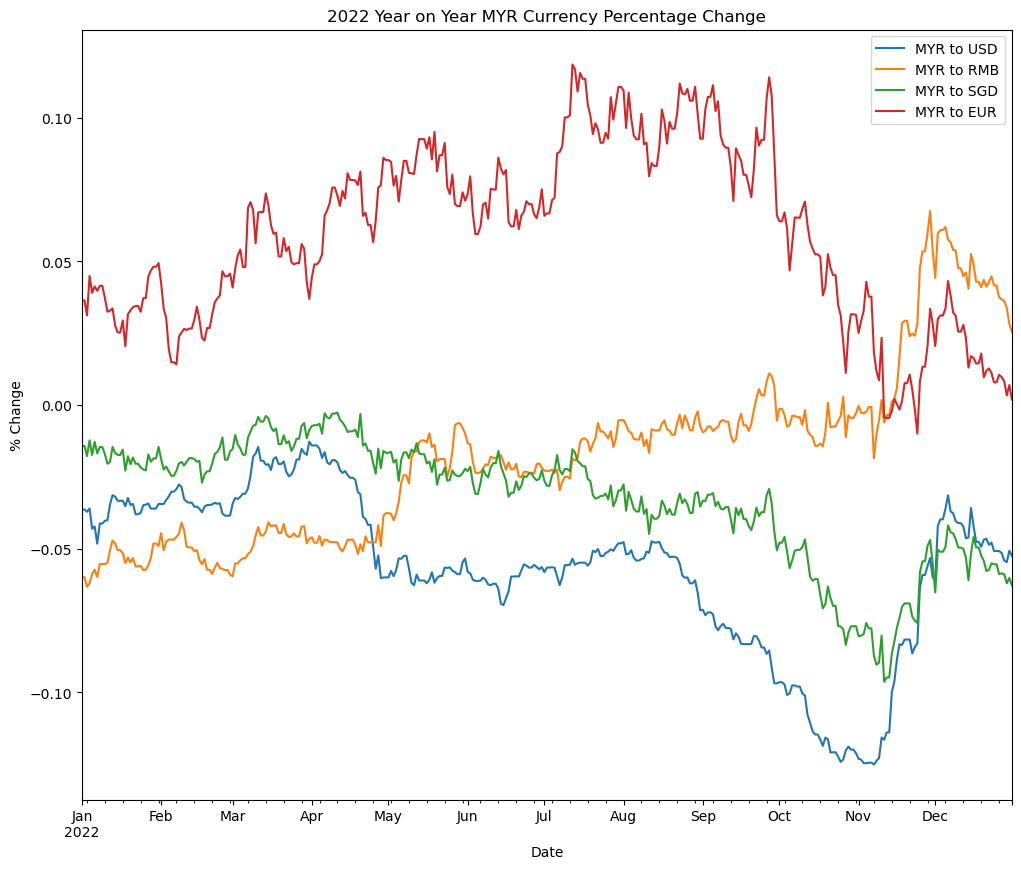

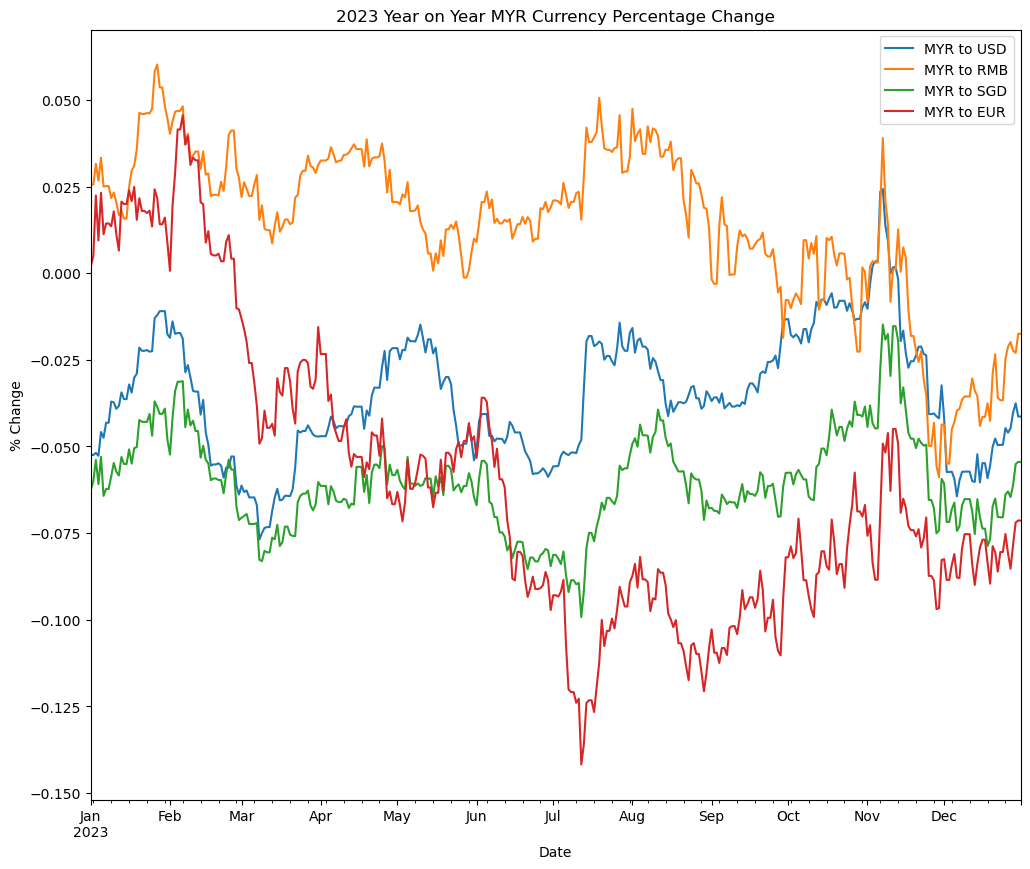

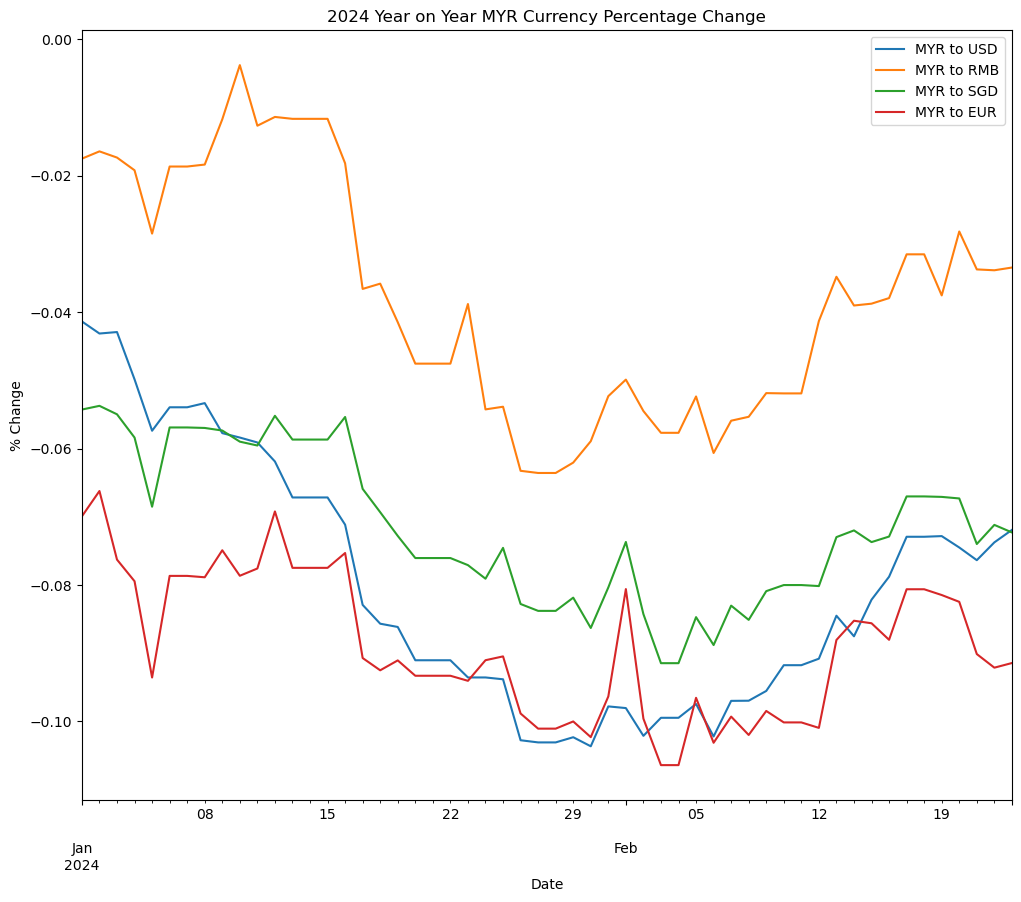

In [8]:
for year, df in result_dfs.items():
    # Column rename 
    col_mapping = {}

    # Column renaming for plotting
    for col in df.columns:
        if col == "date": continue 
        col_list = col.split("_")
        myr, ext = col_list[:2]
        col_mapping[col] = f"{myr.upper()} to {ext.upper()}"
    df = df.rename(columns=col_mapping)


    figure = df.plot(
        x="date",
        title=f"{year} Year on Year MYR Currency Percentage Change",
        xlabel="Date",
        ylabel="% Change",
        figsize=(12,10)
    ).get_figure()

    figure.savefig(f"{year}_currency_percentage_change.jpg")

### Show trend over time
Visualizing only year to date data

In [9]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [15]:
today_ts = datetime.now()
last_year_ts = today_ts - relativedelta(years=1)

today_date = str(today_ts.date())
last_year_date = str(last_year_ts.date())
str(today_date)

'2024-02-24'

In [16]:
# Retrieve data based on date timeframe (YTD)
past_year_df = all_df[(all_df["date"] > last_year_date) & (all_df["date"] <= today_date)]
past_year_df = past_year_df[selected_cols]

In [17]:
# Column renaming
col_mapping = {col: col.upper().replace("_", " to ") for col in past_year_df.columns if col != "date"}
past_year_df = past_year_df.rename(columns=col_mapping)

In [25]:
past_year_df = past_year_df.set_index("date")

In [34]:
# Min Max normalization
# If we straight away visualize it without normalization, it will be extermely hard to read since different currencies have different values.
normalized_df = (past_year_df-past_year_df.min())/(past_year_df.max()-past_year_df.min())

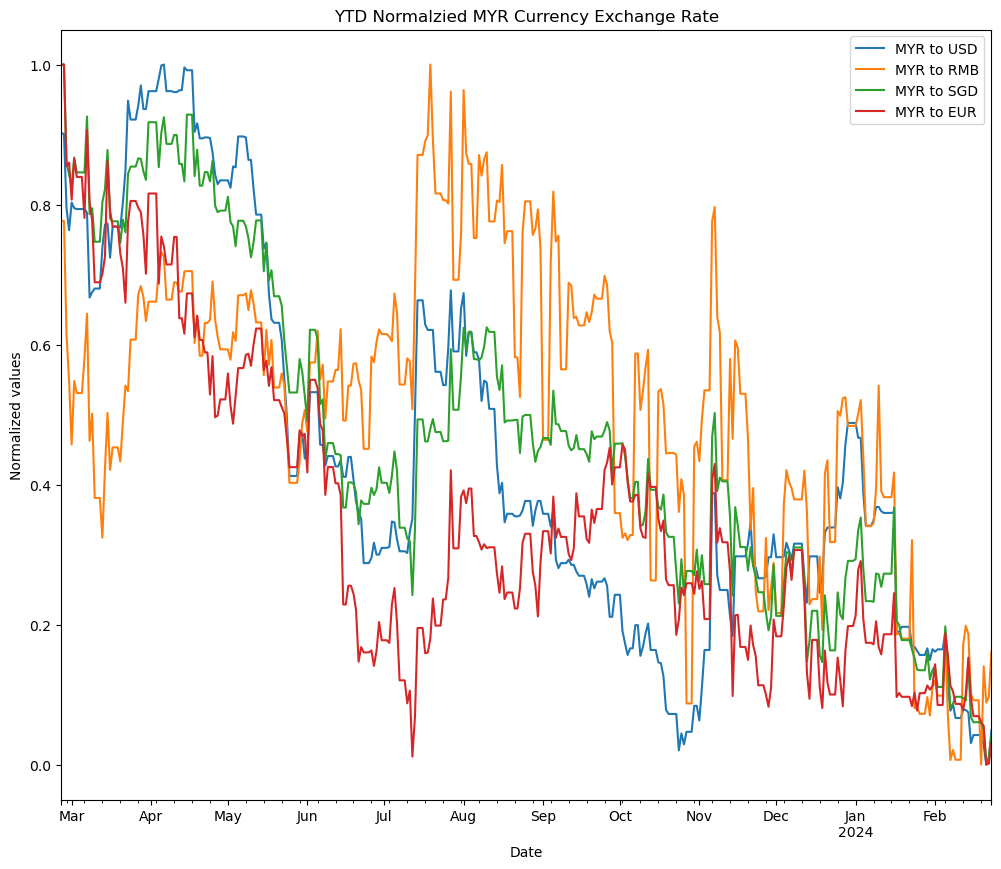

In [39]:
figure = normalized_df.plot(
    title=f"YTD Normalzied MYR Currency Exchange Rate",
    xlabel="Date",
    ylabel="Normalized values",
    figsize=(12,10)
).get_figure()

figure.savefig(f"ytd_normalized_myr_currency_exchange_rate.jpg")